# Lib*

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, GRU
# from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
%matplotlib inline

Using TensorFlow backend.


#Load and prepare data

In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = 'https://drive.google.com/file/d/1PHXYtRKgB0DByjv5EwidMwGGk3zW98sr/view?usp=sharing'

In [0]:
downloaded = drive.CreateFile({'id':"1PHXYtRKgB0DByjv5EwidMwGGk3zW98sr"}) 
downloaded.GetContentFile('farsnews.csv') 

downloaded = drive.CreateFile({'id':"1Mu5iTWps3ykGqEsuFSuUgrId-8T1xJQw"}) 
downloaded.GetContentFile('isna.csv') 

downloaded = drive.CreateFile({'id':"1h2KxuUM1uLR0kd5KmgHYBGYX4vO8SqAH"}) 
downloaded.GetContentFile('tabnak.csv') 

downloaded = drive.CreateFile({'id':"1P7npLlwYpyHq3itqiFMCoY1E0LLN4T0Y"}) 
downloaded.GetContentFile('yjc.csv') 

In [0]:
DfFarsnews = pd.read_csv('farsnews.csv')
DfTabnak = pd.read_csv('tabnak.csv')
DfIsna = pd.read_csv('isna.csv')
DfYjc = pd.read_csv('yjc.csv')
# DfTasnim = pd.read_csv('tasnim.csv')

#Concat
df = pd.concat([DfFarsnews,DfIsna,DfTabnak,DfYjc],axis=0,ignore_index=1)
df = df.rename(columns={'newsagency':'Class'})
df.drop(['tags','datetime','reporter','code'],axis = 1 , inplace =True)


# df["article"] = df["title"].map(str)+ df["summary"].map(str)+ df["text"].map(str)

In [0]:
for i in np.where(pd.isnull(df.title)):
    df["title"][i] = " "
    
for i in np.where(pd.isnull(df.summary)):
    df["summary"][i] = " "
    
for i in np.where(pd.isnull(df.text)):
    df["text"][i] = " "

In [0]:
df["article"]= df["title"]+df["summary"]+ df["text"]

In [0]:
# np.where(pd.isnull(df.title))
# np.where(pd.isnull(df.summary))
# np.where(pd.isnull(df.text))

In [0]:
# print("title = {}\n".format(df.title[1]))
# print("summary = {}\n".format(df.summary[1]))
# print("text = {}\n".format(df.text[1]))
# print("متن کامل خبر = {}\n".format(df.article[1]))

In [0]:
# df.info()

In [0]:
df.isnull().sum()

title      0
summary    0
text       0
Class      0
article    0
dtype: int64

# Remove null article*

In [0]:
df["article"].dropna(axis=0,inplace=True)

In [0]:
df["article"].isnull().sum()

0

In [0]:
df.Class.replace('خبرگزاری فارس','FarsNews',inplace=True)
df.Class.replace('خبرگزاری ایسنا','Isna',inplace=True)
df.Class.replace('خبرگزاری تابناک','Tabnak',inplace=True)
df.Class.replace('باشگاه خبرنگاران جوان','YJC',inplace=True)
# df.Class.replace('خبرگزاری بی بی سی','BBC',inplace=True)
# df.Class.replace('خبرگزاری تسنیم','Tasnim',inplace=True)

df.reset_index(drop=True,inplace=True)
df.head()

,title,summary,text,Class,article
0,بازگشایی سوله‌های مدیریت بحران برای اسکان شرکت...,با دستور شهردار تهران سوله‌های مدیریت بحران در...,غلام محمدی مشاور شهردار تهران و رئیس مرکز اطلا...,FarsNews,بازگشایی سوله‌های مدیریت بحران برای اسکان شرکت...
1,صادقیانی: مسیر صعود به المپیک دشوار نیست/ تیم‌...,بازیکن پیشین تیم ملی والیبال گفت: مسیر صعود وا...,آرش صادقیانی در گفت‌وگو با خبرنگار ورزشی خبرگز...,FarsNews,صادقیانی: مسیر صعود به المپیک دشوار نیست/ تیم‌...
2,حداکثر می‌توان با وام ۲۰۰ میلیون تومانی 10 تا ...,رییس کمیسیون عمران مجلس شورای اسلامی با اشاره ...,به گزارش خبرگزاری فارس به نقل از پایگاه خبری و...,FarsNews,حداکثر می‌توان با وام ۲۰۰ میلیون تومانی 10 تا ...
3,سازمان بسیج هنرمندان کشور «خاتم سلیمانی» را من...,گزیده‌ای از مجموعه اشعار شاعران انقلابی کشور د...,به گزارش خبرگزاری فارس، گزیده‌ای از مجموعه اشع...,FarsNews,سازمان بسیج هنرمندان کشور «خاتم سلیمانی» را من...
4,آمریکا منتظر انتقامی باشد که حتی فکرش را هم نم...,فرمانده قرارگاه حمزه سیدالشهدا(ع) نیروی زمینی ...,به گزارش خبرگزاری فارس از ارومیه، محمدتقی اوصا...,FarsNews,آمریکا منتظر انتقامی باشد که حتی فکرش را هم نم...


# stop word

In [0]:
UnWanted_word=["1","2","3","4","5","6","7","8","9","(",")","/","\xa0","\u200c","\n","\t","انتهای پیام","  "]
for i in UnWanted_word :
    df.article = df.article.str.replace(i, " ")
df.article[0]  
    

'بازگشایی سوله های مدیریت بحران برای اسکان شرکت کنندگان در مراسم تشییع حاج قاسم سلیمانیبا دستور شهردار تهران سوله های مدیریت بحران در مناطق  گانه برای استفاده شرکت کنندگان شهرستانی در مراسم تشییع حاج قاسم سلیمانی تجهیز شده است.غلام محمدی مشاور شهردار تهران و رئیس مرکز اطلاع رسانی شهرداری تهران در گفت وگو با خبرنگار شهری خبرگزاری فارس، گفت: بر اساس پیش بینی های انجام شده به این نتیجه رسیدیم که خیل زیادی از هموطنان کشورمان از شهرهای مختلف برای شرکت در تشییع جنازه سردار حاج قاسم سلیمانی عازم تهران خواهند شد. وی افزود: از این رو شهردار تهران دستور دادند تا تمامی سوله های مدیریت بحران برای اسکان و پذیرایی از این افراد تجهیز شود. محمدی گفت: از این رو امروز و فردا در سوله های مدیریت بحران به روی عزیزانی که از شهرهای مختلف برای شرکت در مراسم تشییع پیکر سردار سلیمانی حضور پیدا می کنند باز خواهد بود تا دغدغه ای برای اسکان نداشته باشند. مشاور شهردار تهران خاطرنشان کرد: این در حالی است که تمهیدات لازم از سوی شرکت اتوبوسرانی، شرکت مترو و خدمات شهری برای هرچه بهتر برگزار شدن این مراسم اندیشیده شده ا

In [0]:
X = df.article
Y = df.Class
Y = pd.get_dummies(df['Class']).values
Y
# le = LabelEncoder()
# Y = le.fit_transform(Y)
# np.unique(Y)
# Y = Y.reshape(-1,1)


array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       ...,
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1]], dtype=uint8)

Text(0.5, 1.0, 'Count of News for every NewsAgency')

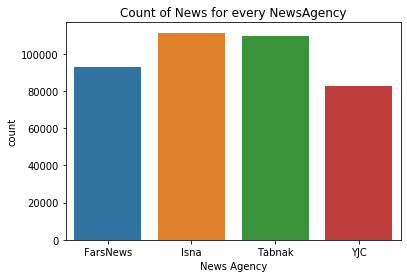

In [0]:
sns.countplot(df.Class)
plt.xlabel('News Agency')
plt.title('Count of News for every NewsAgency')

In [0]:
df.Class.value_counts()

Isna        111297
Tabnak      109698
FarsNews     92927
YJC          82581
Name: Class, dtype: int64

In [0]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15,random_state=42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(337027,) (337027, 4)
(59476,) (59476, 4)


In [0]:
df["Len"]= df["article"].str.len() 
df

,title,summary,text,Class,article,Len
0,بازگشایی سوله‌های مدیریت بحران برای اسکان شرکت...,با دستور شهردار تهران سوله‌های مدیریت بحران در...,غلام محمدی مشاور شهردار تهران و رئیس مرکز اطلا...,FarsNews,بازگشایی سوله های مدیریت بحران برای اسکان شرکت...,1098
1,صادقیانی: مسیر صعود به المپیک دشوار نیست/ تیم‌...,بازیکن پیشین تیم ملی والیبال گفت: مسیر صعود وا...,آرش صادقیانی در گفت‌وگو با خبرنگار ورزشی خبرگز...,FarsNews,صادقیانی: مسیر صعود به المپیک دشوار نیست تیم ه...,1619
2,حداکثر می‌توان با وام ۲۰۰ میلیون تومانی 10 تا ...,رییس کمیسیون عمران مجلس شورای اسلامی با اشاره ...,به گزارش خبرگزاری فارس به نقل از پایگاه خبری و...,FarsNews,حداکثر می توان با وام ۲۰۰ میلیون تومانی 0 تا ...,2524
3,سازمان بسیج هنرمندان کشور «خاتم سلیمانی» را من...,گزیده‌ای از مجموعه اشعار شاعران انقلابی کشور د...,به گزارش خبرگزاری فارس، گزیده‌ای از مجموعه اشع...,FarsNews,سازمان بسیج هنرمندان کشور «خاتم سلیمانی» را من...,1407
4,آمریکا منتظر انتقامی باشد که حتی فکرش را هم نم...,فرمانده قرارگاه حمزه سیدالشهدا(ع) نیروی زمینی ...,به گزارش خبرگزاری فارس از ارومیه، محمدتقی اوصا...,FarsNews,آمریکا منتظر انتقامی باشد که حتی فکرش را هم نم...,2211
...,...,...,...,...,...,...
396498,شکست سنگین روس‌ها / برزیلی‌ها همچنان روی نوار برد,تیم ملی والیبال روسیه امروز در سومین دیدار روز...,به گزارش خبرنگار توپ و تور گروه ورزش باشگاه خب...,YJC,شکست سنگین روس ها برزیلی ها همچنان روی نوار ب...,1056
396499,آخرین وضعیت جاده‌های مازندران/ محدودیت‌های ترا...,رییس پلیس راه مازندران گفت: محدودیت‌های ترافیک...,سرهنگ علیرضا قدمی رییس پلیس راه مازندران در گف...,YJC,آخرین وضعیت جاده های مازندران محدودیت های تراف...,1073
396500,رقابت دو تیم رایکا بابل فجرسپاسی شیراز,تیم رایکا بابل از ساعت ۱۵ امروز شنبه ۱۳ مهر ما...,به گزارش گروه استان های باشگاه خبرنگاران جوان ...,YJC,رقابت دو تیم رایکا بابل فجرسپاسی شیرازتیم رایک...,1234
396501,احداث ۲ هزار واحد مسکونی ارزان قیمت از سوی ستا...,استاندار کرمانشاه گفت: شهرداری کرمانشاه باید ه...,به گزارش گروه استان های باشگاه خبرنگاران جوان...,YJC,احداث ۲ هزار واحد مسکونی ارزان قیمت از سوی ستا...,1784


In [0]:
df['TokenCount']= df["article"].str.len() 
df

,title,summary,text,Class,article,Len,TokenCount
0,بازگشایی سوله‌های مدیریت بحران برای اسکان شرکت...,با دستور شهردار تهران سوله‌های مدیریت بحران در...,غلام محمدی مشاور شهردار تهران و رئیس مرکز اطلا...,FarsNews,بازگشایی سوله های مدیریت بحران برای اسکان شرکت...,1098,1098
1,صادقیانی: مسیر صعود به المپیک دشوار نیست/ تیم‌...,بازیکن پیشین تیم ملی والیبال گفت: مسیر صعود وا...,آرش صادقیانی در گفت‌وگو با خبرنگار ورزشی خبرگز...,FarsNews,صادقیانی: مسیر صعود به المپیک دشوار نیست تیم ه...,1619,1619
2,حداکثر می‌توان با وام ۲۰۰ میلیون تومانی 10 تا ...,رییس کمیسیون عمران مجلس شورای اسلامی با اشاره ...,به گزارش خبرگزاری فارس به نقل از پایگاه خبری و...,FarsNews,حداکثر می توان با وام ۲۰۰ میلیون تومانی 0 تا ...,2524,2524
3,سازمان بسیج هنرمندان کشور «خاتم سلیمانی» را من...,گزیده‌ای از مجموعه اشعار شاعران انقلابی کشور د...,به گزارش خبرگزاری فارس، گزیده‌ای از مجموعه اشع...,FarsNews,سازمان بسیج هنرمندان کشور «خاتم سلیمانی» را من...,1407,1407
4,آمریکا منتظر انتقامی باشد که حتی فکرش را هم نم...,فرمانده قرارگاه حمزه سیدالشهدا(ع) نیروی زمینی ...,به گزارش خبرگزاری فارس از ارومیه، محمدتقی اوصا...,FarsNews,آمریکا منتظر انتقامی باشد که حتی فکرش را هم نم...,2211,2211
...,...,...,...,...,...,...,...
396498,شکست سنگین روس‌ها / برزیلی‌ها همچنان روی نوار برد,تیم ملی والیبال روسیه امروز در سومین دیدار روز...,به گزارش خبرنگار توپ و تور گروه ورزش باشگاه خب...,YJC,شکست سنگین روس ها برزیلی ها همچنان روی نوار ب...,1056,1056
396499,آخرین وضعیت جاده‌های مازندران/ محدودیت‌های ترا...,رییس پلیس راه مازندران گفت: محدودیت‌های ترافیک...,سرهنگ علیرضا قدمی رییس پلیس راه مازندران در گف...,YJC,آخرین وضعیت جاده های مازندران محدودیت های تراف...,1073,1073
396500,رقابت دو تیم رایکا بابل فجرسپاسی شیراز,تیم رایکا بابل از ساعت ۱۵ امروز شنبه ۱۳ مهر ما...,به گزارش گروه استان های باشگاه خبرنگاران جوان ...,YJC,رقابت دو تیم رایکا بابل فجرسپاسی شیرازتیم رایک...,1234,1234
396501,احداث ۲ هزار واحد مسکونی ارزان قیمت از سوی ستا...,استاندار کرمانشاه گفت: شهرداری کرمانشاه باید ه...,به گزارش گروه استان های باشگاه خبرنگاران جوان...,YJC,احداث ۲ هزار واحد مسکونی ارزان قیمت از سوی ستا...,1784,1784


In [0]:
# max_len = 10000
# min_count = 10

In [0]:
MeanArticle =np.mean(df.TokenCount)
print("mean len sentence : {:.2f}".format(MeanArticle))
print("Min length =",min(df.TokenCount))
print("Max length =",max(df.TokenCount))
print("mean = {:.2f}".format(np.mean(df.TokenCount)))
print("std = {:.2f} ".format(np.std(df.TokenCount)))
print("mean + 2 * sigma ={:.2f} ".format(np.mean(df.TokenCount) + 2 * np.std(df.TokenCount)))

mean len sentence : 2101.11
Min length = 2
Max length = 145993
mean = 2101.11
std = 2406.48 
mean + 2 * sigma =6914.07 


In [0]:
# Parameter setting

# The maximum number of words to be used. (most frequent)
max_words = 1000

# Max number of words in each document.
max_len = 300

tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train.values)
sequences = tok.texts_to_sequences(X_train.values)

# Pad sequencing to make all inputs in the same length of input
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)
print('Shape of data tensor:',sequences_matrix.shape)

Shape of data tensor: (337027, 300)


In [0]:
word_index = tok.word_index
print('Found %s unique tokens.' % len(word_index))
#print('Found {} unique tokens.'.format(len(word_index)))

Found 777154 unique tokens.


In [0]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = GRU(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(4,name='out_layer')(layer)
    layer = Activation('softmax')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [0]:
model = RNN()
model.summary()
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 300)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 300, 50)           50000     
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                22080     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_3 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 4)                 1028

In [0]:
history = model.fit(sequences_matrix,Y_train,batch_size=128,epochs=,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Train on 269621 samples, validate on 67406 samples
Epoch 1/10
269621/269621 [==============================] - 1113s 4ms/step - loss: 0.6716 - acc: 0.7063 - val_loss: 0.4053 - val_acc: 0.8389
Epoch 2/10
269621/269621 [==============================] - 1099s 4ms/step - loss: 0.3781 - acc: 0.8495 - val_loss: 0.3546 - val_acc: 0.8569
Epoch 3/10
269621/269621 [==============================] - 1106s 4ms/step - loss: 0.3383 - acc: 0.8627 - val_loss: 0.3307 - val_acc: 0.8648
Epoch 4/10
269621/269621 [==============================] - 1106s 4ms/step - loss: 0.3137 - acc: 0.8719 - val_loss: 0.3103 - val_acc: 0.8731
Epoch 5/10
269621/269621 [==============================] - 1142s 4ms/step - loss: 0.2930 - acc: 0.8796 - val_loss: 0.3010 - val_acc: 0.8767
Epoch 6/10
269621/269621 [==============================] - 1139s 4ms/step - loss: 0.2774 - acc: 0.8861 - val_loss: 0.2914 - val_acc: 0.8815
Epoch 7/10
269621/269621 [==============================] - 1150s 4ms/step - loss: 0.2655 - acc: 0.8908

In [0]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

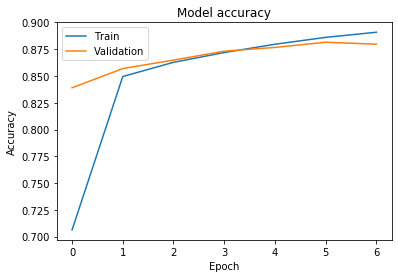

In [0]:

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

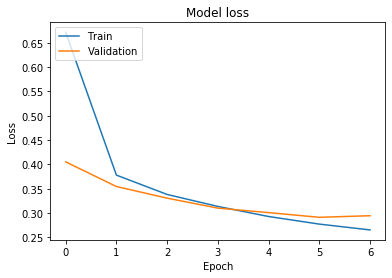

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [0]:
accr = model.evaluate(test_sequences_matrix,Y_test)

59476/59476 [==============================] - 333s 6ms/step


In [0]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.291
  Accuracy: 0.881
